<a href="https://colab.research.google.com/github/khushichhabra7921/StockPricePrediction/blob/main/StockPricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Stock Market Prediction using Time Series Machine Learning
# Complete project with data collection, preprocessing, and multiple ML models

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [2]:
# ML Libraries
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression

In [3]:
# Deep Learning
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, LSTM, Dropout
    from tensorflow.keras.optimizers import Adam
    TENSORFLOW_AVAILABLE = True
except ImportError:
    TENSORFLOW_AVAILABLE = False
    print("TensorFlow not available. LSTM models will be skipped.")

In [4]:
# Technical Analysis
try:
    import talib
    TALIB_AVAILABLE = True
except ImportError:
    TALIB_AVAILABLE = False
    print("TA-Lib not available. Using custom technical indicators.")


TA-Lib not available. Using custom technical indicators.


🚀 Starting Stock Prediction Analysis for AAPL
✓ Successfully fetched 502 days of data for AAPL
✓ Created 42 features with 302 samples
✓ Train set: 241 samples, Test set: 61 samples

Training Linear Regression...
  RMSE: 9.7765
  MAE: 8.6223
  R²: -0.7819

Training Ridge Regression...
  RMSE: 6.2942
  MAE: 4.7964
  R²: 0.2614

Training Random Forest...
  RMSE: 11.1454
  MAE: 9.4099
  R²: -1.3158

Training Gradient Boosting...
  RMSE: 11.1376
  MAE: 9.2848
  R²: -1.3126

Training SVR...
  RMSE: 15.1545
  MAE: 13.1613
  R²: -3.2814
✓ Train set: 241 samples, Test set: 61 samples

Training LSTM...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
  RMSE: 211.4524
  MAE: 211.4524
  R²: nan

STOCK PREDICTION SUMMARY FOR AAPL
Model                RMSE         MAE          R²          
------------------------------------------------------------
Ridge Regression     6.2942       4.7964       0.2614      
Linear Regression    9.7765       8.6223       -0.7819     
Gradient Boosting    11.1376      9.2848  

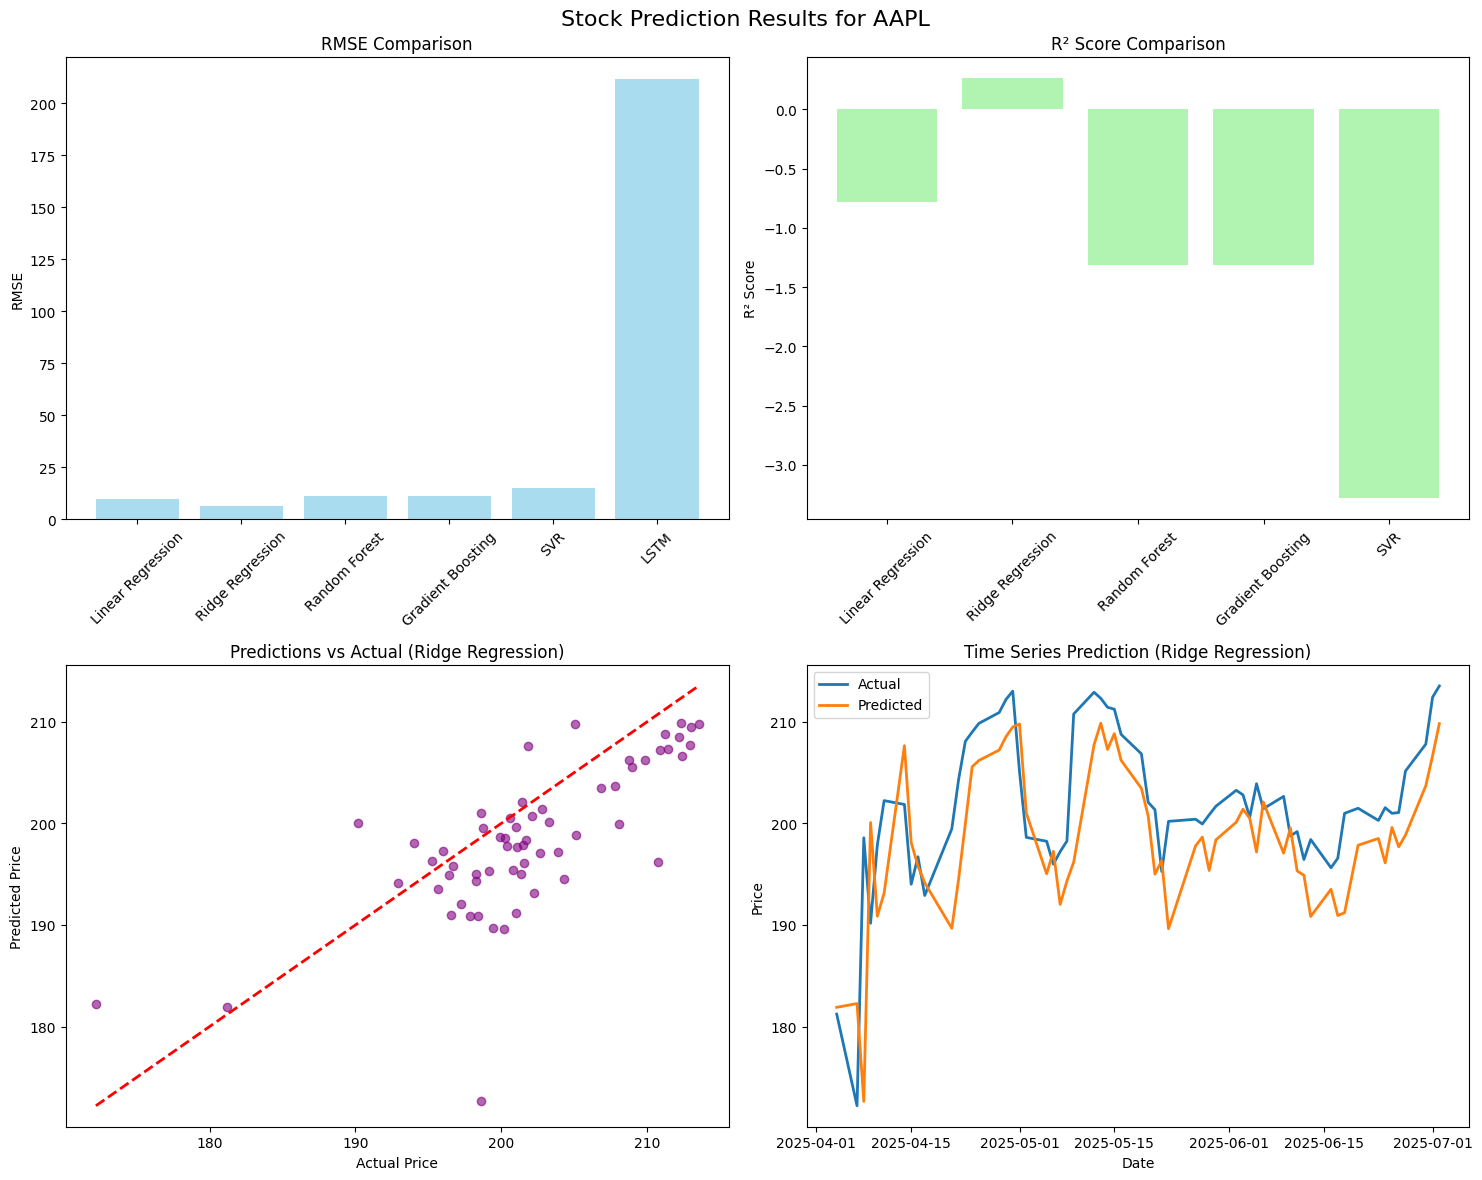


🔮 NEXT DAY PREDICTION (Ridge Regression)
Current Price: $213.55
Predicted Price: $209.84
Predicted Change: $-3.71 (-1.74%)


In [5]:
class StockPredictor:
    def __init__(self, symbol='AAPL', period='5y'):
        """
        Initialize the Stock Predictor

        Parameters:
        symbol (str): Stock symbol (e.g., 'AAPL', 'GOOGL', 'MSFT')
        period (str): Time period for data ('1y', '2y', '5y', '10y', 'max')
        """
        self.symbol = symbol
        self.period = period
        self.data = None
        self.features = None
        self.models = {}
        self.scalers = {}
        self.results = {}

    def fetch_data(self):
        """Fetch stock data from Yahoo Finance"""
        try:
            stock = yf.Ticker(self.symbol)
            self.data = stock.history(period=self.period)
            print(f"✓ Successfully fetched {len(self.data)} days of data for {self.symbol}")
            return True
        except Exception as e:
            print(f"✗ Error fetching data: {e}")
            return False

    def calculate_technical_indicators(self):
        """Calculate technical indicators"""
        df = self.data.copy()

        # Price-based indicators
        df['Returns'] = df['Close'].pct_change()
        df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))

        # Moving averages
        for window in [5, 10, 20, 50, 200]:
            df[f'SMA_{window}'] = df['Close'].rolling(window=window).mean()
            df[f'EMA_{window}'] = df['Close'].ewm(span=window).mean()

        # Volatility
        df['Volatility_10'] = df['Returns'].rolling(window=10).std()
        df['Volatility_30'] = df['Returns'].rolling(window=30).std()

        # RSI (Relative Strength Index)
        def calculate_rsi(prices, window=14):
            delta = prices.diff()
            gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
            rs = gain / loss
            rsi = 100 - (100 / (1 + rs))
            return rsi

        df['RSI'] = calculate_rsi(df['Close'])

        # MACD
        exp1 = df['Close'].ewm(span=12).mean()
        exp2 = df['Close'].ewm(span=26).mean()
        df['MACD'] = exp1 - exp2
        df['MACD_Signal'] = df['MACD'].ewm(span=9).mean()
        df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']

        # Bollinger Bands
        df['BB_Middle'] = df['Close'].rolling(window=20).mean()
        bb_std = df['Close'].rolling(window=20).std()
        df['BB_Upper'] = df['BB_Middle'] + (bb_std * 2)
        df['BB_Lower'] = df['BB_Middle'] - (bb_std * 2)
        df['BB_Width'] = df['BB_Upper'] - df['BB_Lower']
        df['BB_Position'] = (df['Close'] - df['BB_Lower']) / (df['BB_Upper'] - df['BB_Lower'])

        # Price position indicators
        df['Price_Position_20'] = df['Close'] / df['Close'].rolling(window=20).max()
        df['Price_Position_50'] = df['Close'] / df['Close'].rolling(window=50).max()

        # Volume indicators
        df['Volume_SMA_10'] = df['Volume'].rolling(window=10).mean()
        df['Volume_Ratio'] = df['Volume'] / df['Volume_SMA_10']

        # Lagged features
        for lag in [1, 2, 3, 5, 10]:
            df[f'Close_Lag_{lag}'] = df['Close'].shift(lag)
            df[f'Volume_Lag_{lag}'] = df['Volume'].shift(lag)
            df[f'Returns_Lag_{lag}'] = df['Returns'].shift(lag)

        # Target variable (next day's closing price)
        df['Target'] = df['Close'].shift(-1)

        return df

    def prepare_features(self):
        """Prepare features for machine learning"""
        df = self.calculate_technical_indicators()

        # Select feature columns (exclude basic OHLCV and target)
        feature_cols = [col for col in df.columns if col not in
                       ['Open', 'High', 'Low', 'Close', 'Volume', 'Target', 'Dividends', 'Stock Splits']]

        # Create feature matrix
        self.features = df[feature_cols + ['Target']].dropna()

        print(f"✓ Created {len(feature_cols)} features with {len(self.features)} samples")
        return feature_cols

    def split_data(self, test_size=0.2):
        """Split data into train and test sets using time series split"""
        # Sort by date to ensure proper time series split
        self.features = self.features.sort_index()

        # Split features and target
        X = self.features.drop('Target', axis=1)
        y = self.features['Target']

        # Time series split (use last 20% for testing)
        split_idx = int(len(X) * (1 - test_size))

        X_train = X.iloc[:split_idx]
        X_test = X.iloc[split_idx:]
        y_train = y.iloc[:split_idx]
        y_test = y.iloc[split_idx:]

        print(f"✓ Train set: {len(X_train)} samples, Test set: {len(X_test)} samples")

        return X_train, X_test, y_train, y_test

    def train_models(self):
        """Train multiple ML models"""
        X_train, X_test, y_train, y_test = self.split_data()

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        self.scalers['standard'] = scaler

        # Define models
        models = {
            'Linear Regression': LinearRegression(),
            'Ridge Regression': Ridge(alpha=1.0),
            'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
            'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
            'SVR': SVR(kernel='rbf', C=1.0, gamma='scale')
        }

        # Train and evaluate models
        for name, model in models.items():
            print(f"\nTraining {name}...")

            # Use scaled data for linear models and SVR
            if name in ['Linear Regression', 'Ridge Regression', 'SVR']:
                model.fit(X_train_scaled, y_train)
                y_pred = model.predict(X_test_scaled)
            else:
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

            # Calculate metrics
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            # Store results
            self.models[name] = model
            self.results[name] = {
                'MSE': mse,
                'RMSE': rmse,
                'MAE': mae,
                'R2': r2,
                'predictions': y_pred,
                'actual': y_test
            }

            print(f"  RMSE: {rmse:.4f}")
            print(f"  MAE: {mae:.4f}")
            print(f"  R²: {r2:.4f}")

    def create_lstm_model(self, X_train, y_train, X_test, y_test, sequence_length=60):
        """Create and train LSTM model"""
        if not TENSORFLOW_AVAILABLE:
            print("TensorFlow not available. Skipping LSTM model.")
            return

        # Prepare data for LSTM
        def create_sequences(data, seq_length):
            X, y = [], []
            for i in range(seq_length, len(data)):
                X.append(data[i-seq_length:i])
                y.append(data[i])
            return np.array(X), np.array(y)

        # Scale features for LSTM
        feature_scaler = MinMaxScaler()
        X_train_scaled = feature_scaler.fit_transform(X_train)
        X_test_scaled = feature_scaler.transform(X_test)

        # Create sequences for features
        X_train_seq, _ = create_sequences(X_train_scaled, sequence_length)
        X_test_seq, _ = create_sequences(X_test_scaled, sequence_length)

        # Scale target variable for LSTM
        target_scaler = MinMaxScaler()
        y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
        y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))


        # Create sequences for target
        _, y_train_seq = create_sequences(y_train_scaled, sequence_length)
        _, y_test_seq = create_sequences(y_test_scaled, sequence_length)


        if len(X_train_seq) == 0 or len(X_test_seq) == 0:
            print("Not enough data for LSTM sequences. Skipping LSTM model.")
            return

        # Build LSTM model
        model = Sequential([
            LSTM(50, return_sequences=True, input_shape=(sequence_length, X_train.shape[1])),
            Dropout(0.2),
            LSTM(50, return_sequences=False),
            Dropout(0.2),
            Dense(25),
            Dense(1)
        ])

        model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

        # Train model
        print("\nTraining LSTM...")
        history = model.fit(
            X_train_seq, y_train_seq,
            batch_size=32,
            epochs=50,
            validation_split=0.2,
            verbose=0
        )

        # Make predictions
        y_pred_scaled = model.predict(X_test_seq)

        # Inverse transform predictions to original scale
        y_pred = target_scaler.inverse_transform(y_pred_scaled)


        # Calculate metrics
        mse = mean_squared_error(y_test_seq, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test_seq, y_pred)
        r2 = r2_score(y_test_seq, y_pred)

        # Store results
        self.models['LSTM'] = model
        self.scalers['lstm_features'] = feature_scaler
        self.scalers['lstm_target'] = target_scaler

        self.results['LSTM'] = {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2,
            'predictions': y_pred.flatten(),
            'actual': y_test.iloc[sequence_length:].values,  # Adjust actual to match sequence length
            'history': history.history
        }

        print(f"  RMSE: {rmse:.4f}")
        print(f"  MAE: {mae:.4f}")
        print(f"  R²: {r2:.4f}")

    def plot_results(self):
        """Plot model results"""
        n_models = len(self.results)
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle(f'Stock Prediction Results for {self.symbol}', fontsize=16)

        # Performance comparison
        models = list(self.results.keys())
        rmse_scores = [self.results[model]['RMSE'] for model in models]
        r2_scores = [self.results[model]['R2'] for model in models]

        axes[0, 0].bar(models, rmse_scores, color='skyblue', alpha=0.7)
        axes[0, 0].set_title('RMSE Comparison')
        axes[0, 0].set_ylabel('RMSE')
        axes[0, 0].tick_params(axis='x', rotation=45)

        axes[0, 1].bar(models, r2_scores, color='lightgreen', alpha=0.7)
        axes[0, 1].set_title('R² Score Comparison')
        axes[0, 1].set_ylabel('R² Score')
        axes[0, 1].tick_params(axis='x', rotation=45)

        # Prediction vs Actual for best model
        best_model = min(self.results.keys(), key=lambda x: self.results[x]['RMSE'])
        best_results = self.results[best_model]

        axes[1, 0].scatter(best_results['actual'], best_results['predictions'],
                          alpha=0.6, color='purple')
        axes[1, 0].plot([best_results['actual'].min(), best_results['actual'].max()],
                       [best_results['actual'].min(), best_results['actual'].max()],
                       'r--', lw=2)
        axes[1, 0].set_xlabel('Actual Price')
        axes[1, 0].set_ylabel('Predicted Price')
        axes[1, 0].set_title(f'Predictions vs Actual ({best_model})')

        # Time series plot
        actual = best_results['actual']
        predicted = best_results['predictions']

        # Ensure actual and predicted have the same index for plotting
        actual_index = self.features.index[len(self.features) - len(actual):]

        axes[1, 1].plot(actual_index, actual, label='Actual', linewidth=2)
        axes[1, 1].plot(actual_index, predicted, label='Predicted', linewidth=2)
        axes[1, 1].set_xlabel('Date')
        axes[1, 1].set_ylabel('Price')
        axes[1, 1].set_title(f'Time Series Prediction ({best_model})')
        axes[1, 1].legend()

        plt.tight_layout()
        plt.show()

    def print_summary(self):
        """Print summary of results"""
        print(f"\n{'='*60}")
        print(f"STOCK PREDICTION SUMMARY FOR {self.symbol}")
        print(f"{'='*60}")

        # Sort models by RMSE
        sorted_models = sorted(self.results.items(), key=lambda x: x[1]['RMSE'])

        print(f"{'Model':<20} {'RMSE':<12} {'MAE':<12} {'R²':<12}")
        print("-" * 60)

        for model_name, metrics in sorted_models:
            print(f"{model_name:<20} {metrics['RMSE']:<12.4f} {metrics['MAE']:<12.4f} {metrics['R2']:<12.4f}")

        best_model = sorted_models[0][0]
        print(f"\n🏆 Best Model: {best_model}")
        print(f"📊 Dataset: {len(self.features)} samples, {len(self.features.columns)-1} features")
        print(f"📈 Stock: {self.symbol}")

    def predict_next_day(self, model_name=None):
        """Predict next day's closing price"""
        if model_name is None:
            # Use best model (lowest RMSE)
            model_name = min(self.results.keys(), key=lambda x: self.results[x]['RMSE'])

        if model_name not in self.models:
            print(f"Model {model_name} not found!")
            return None

        # Get latest features
        latest_features = self.features.drop('Target', axis=1).iloc[-1:].values

        # Scale if needed
        if model_name in ['Linear Regression', 'Ridge Regression', 'SVR']:
            latest_features = self.scalers['standard'].transform(latest_features)
        elif model_name == 'LSTM':
             # For LSTM, we need a sequence of the latest features
            if 'lstm_features' not in self.scalers:
                 print("LSTM feature scaler not found. Cannot predict.")
                 return None

            # Get the last 'sequence_length' data points
            sequence_length = 60 # This should ideally be a parameter or derived from the model
            if len(self.features) < sequence_length:
                print(f"Not enough data ({len(self.features)}) to create a sequence of length {sequence_length} for prediction.")
                return None

            latest_sequence_features = self.features.drop('Target', axis=1).iloc[-sequence_length:].values
            latest_sequence_features_scaled = self.scalers['lstm_features'].transform(latest_sequence_features)
            latest_features = latest_sequence_features_scaled.reshape(1, sequence_length, latest_sequence_features_scaled.shape[1])


        # Make prediction
        prediction_scaled = self.models[model_name].predict(latest_features)

        # Inverse transform prediction if LSTM
        if model_name == 'LSTM':
            if 'lstm_target' not in self.scalers:
                 print("LSTM target scaler not found. Cannot inverse transform prediction.")
                 return None
            prediction = self.scalers['lstm_target'].inverse_transform(prediction_scaled)[0][0]
        else:
            prediction = prediction_scaled[0]


        current_price = self.data['Close'].iloc[-1]
        predicted_change = prediction - current_price
        predicted_change_pct = (predicted_change / current_price) * 100

        print(f"\n🔮 NEXT DAY PREDICTION ({model_name})")
        print(f"Current Price: ${current_price:.2f}")
        print(f"Predicted Price: ${prediction:.2f}")
        print(f"Predicted Change: ${predicted_change:.2f} ({predicted_change_pct:+.2f}%)")

        return prediction

    def run_full_analysis(self):
        """Run complete analysis pipeline"""
        print(f"🚀 Starting Stock Prediction Analysis for {self.symbol}")
        print("=" * 60)

        # Fetch data
        if not self.fetch_data():
            return

        # Prepare features
        self.prepare_features()

        # Train models
        self.train_models()

        # Train LSTM if TensorFlow is available
        if TENSORFLOW_AVAILABLE:
            X_train, X_test, y_train, y_test = self.split_data()
            self.create_lstm_model(X_train, y_train, X_test, y_test)

        # Print summary
        self.print_summary()

        # Plot results
        self.plot_results()

        # Predict next day
        self.predict_next_day()

# Example usage
def main():
    # Create predictor for Apple stock
    predictor = StockPredictor(symbol='AAPL', period='2y')

    # Run full analysis
    predictor.run_full_analysis()

    # You can also run individual steps:
    # predictor.fetch_data()
    # predictor.prepare_features()
    # predictor.train_models()
    # predictor.predict_next_day('Random Forest')


if __name__ == "__main__":
    main()